In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import save_model
import matplotlib.pyplot as plt
from bokeh.plotting import output_notebook
from bokeh.plotting import figure, show
import pickle

from TrainCNN import split_dataset, plot_ML_model_loss_bokeh

2025-08-04 12:12:52.011862: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Train Convolutional Neural Network on Spectral Grid 

## **1. Preprocessing**

Prepare the dataset by loading it into a Dataframe with columns corresponding to (1) parameter grid points and (2) model flux at each wavelength. Split into train/val/test, feature engineering, and standardization. 

### 1.1 Load Dataset

In [2]:
# Load or create reference data path
__reference_data_path__ = os.getenv("TelescopeML_reference_data")

# DataFrame with cols grid points then spectra
train_BD = pd.read_csv(os.path.join(__reference_data_path__,
                                    'training_datasets',
                                    'browndwarf_R100_v4_newWL_v3.csv.bz2'), compression='bz2')
# Wavelength grid of model
wl_synthetic = pd.read_csv(os.path.join(__reference_data_path__,
                                        'training_datasets',
                                        'wl.csv'))

In [3]:
# Model parameters
parameters = ['gravity',
             'temperature',
             'c_o_ratio',
             'metallicity']

# Training variables
X = train_BD.drop(
    columns=parameters)

# Target/Output feature variables
y = train_BD[parameters]
# log transform temperature variable
y.loc[:, 'temperature'] = np.log10(y['temperature'])

### 1.2 Split Dataset into Train/Val/Test

In [4]:
X_train, X_test, X_val, y_train, y_test, y_val = split_dataset(flux_values=X.to_numpy(),
                                                               output_values=y.to_numpy())

### 1.3 (Optional) Logscale the spectra

In [5]:
# Logscale model flux 
X_train_log = np.log10(X_train)
X_val_log = np.log10(X_val)
X_test_log = np.log10(X_test)

### 1.4 Standardize X and Y

In [6]:
# Standardize X rowwise
scaler_X = StandardScaler()
X_train_standardized_rowwise = scaler_X.fit_transform(X_train_log.T).T
X_val_standardized_rowwise = scaler_X.fit_transform(X_val_log.T).T
X_test_standardized_rowwise = scaler_X.fit_transform(X_test_log.T).T
standardize_X_RowWise = scaler_X

# Save X scaler 
# with open('scaler_X.pkl', 'wb') as f:
#     pickle.dump(scaler_X, f)
    
# Standardize Y columnwise
scaler_y = StandardScaler()
y_train_standardized_columnwise = scaler_y.fit_transform(y_train)
y_val_standardized_columnwise = scaler_y.transform(y_val)
y_test_standardized_columnwise = scaler_y.transform(y_test)
standardize_y_ColumnWise = scaler_y

# Save Y scaler
# with open('scaler_y.pkl', 'wb') as f:
#     pickle.dump(scaler_y, f)

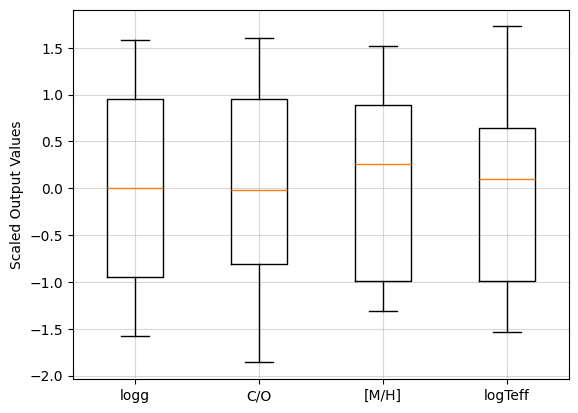

In [7]:
# Check output standardization
plt.boxplot(y_train_standardized_columnwise)
plt.grid(alpha=0.5)
plt.xticks([1,2,3,4],labels=['logg','C/O','[M/H]','logTeff'])
plt.ylabel("Scaled Output Values")
plt.show()

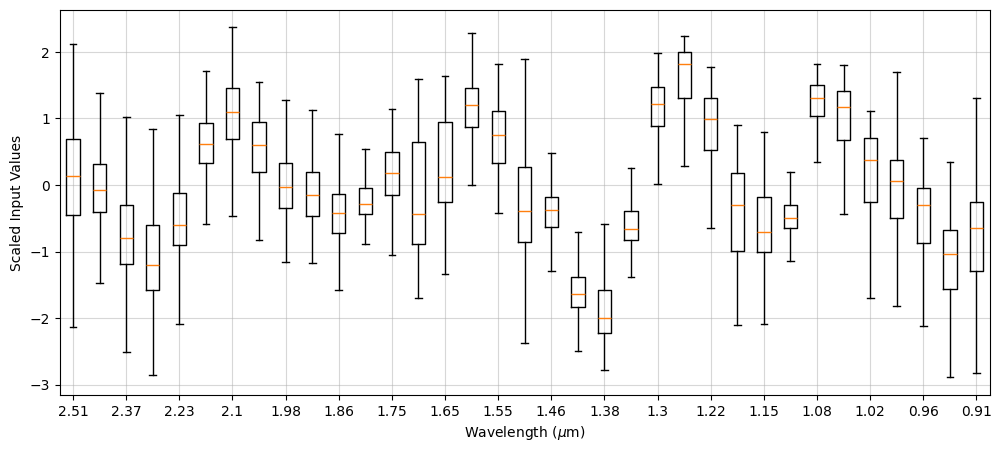

In [58]:
# Check input standardization
plt.figure(figsize=(12,5))
plt.boxplot(X_train_standardized_rowwise[:, ::3],showfliers=False)
plt.xticks(np.arange(1,36,2),labels=np.array(np.round(wl_synthetic,2)).reshape(104)[::6])
plt.xlabel(r"Wavelength ($\mu$m)")
plt.grid(alpha=0.5)
plt.ylabel("Scaled Input Values")
plt.show()

### 1.5 Feature Engineering: Min and Max of each Spectrum

In [8]:
# Create new feature for train, val, and test sets
# train
X_train_min = X_train_log.min(axis=1)
X_train_max = X_train_log.max(axis=1)
# validation
X_val_min = X_val_log.min(axis=1)
X_val_max = X_val_log.max(axis=1)
# test
X_test_min = X_test_log.min(axis=1)
X_test_max = X_test_log.max(axis=1)

# Create DataFrames with new feature
df_MinMax_train = pd.DataFrame((X_train_min, X_train_max)).T
df_MinMax_val = pd.DataFrame((X_val_min, X_val_max)).T
df_MinMax_test = pd.DataFrame((X_test_min, X_test_max)).T

# Rename columns
df_MinMax_train.rename(columns={0:'min', 1:'max'}, inplace=True)
df_MinMax_val.rename(columns={0:'min', 1:'max'}, inplace=True)
df_MinMax_test.rename(columns={0:'min', 1:'max'}, inplace=True)

### 1.6 Standardize Metadata

In [9]:
# Create numpy arrays
X_train_meta = df_MinMax_train.to_numpy()
X_val_meta   = df_MinMax_val.to_numpy()
X_test_meta  = df_MinMax_test.to_numpy()

# Standardize metadeta columnwise
scaler_X = StandardScaler()
X_train_standardized_columnwise = scaler_X.fit_transform(X_train_meta)
X_val_standardized_columnwise = scaler_X.transform(X_val_meta)
X_test_standardized_columnwise = scaler_X.transform(X_test_meta)

# Save meta scaler
# with open('scaler_X_meta.pkl', 'wb') as f:
#     pickle.dump(scaler_X, f)

## **2. Build Model**

Prepare the input and output data for each target, hyperparameter tuning, build model architecture including convolutional layers, compile the model, and save. 

### 2.1 Prepare Input and Output for CNN

In [10]:
# input dataset: StandardScaled instances
X1_train = X_train_standardized_rowwise
X1_val   = X_val_standardized_rowwise
X1_test  = X_test_standardized_rowwise

# input dataset: Min Max of each instance
X2_train = X_train_standardized_columnwise
X2_val   = X_val_standardized_columnwise
X2_test  = X_test_standardized_columnwise

# 1st target
y1_train = y_train_standardized_columnwise[:,0] # logg
y1_val   = y_val_standardized_columnwise[:,0]
y1_test  = y_test_standardized_columnwise[:,0]

# 2nd target
y2_train = y_train_standardized_columnwise[:,1] # C/O
y2_val   = y_val_standardized_columnwise[:,1]
y2_test  = y_test_standardized_columnwise[:,1]

# 3rd target
y3_train = y_train_standardized_columnwise[:,2] # [M/H]
y3_val   = y_val_standardized_columnwise[:,2]
y3_test  = y_test_standardized_columnwise[:,2]

# 4th target
y4_train = y_train_standardized_columnwise[:,3] # logTeff
y4_val   = y_val_standardized_columnwise[:,3]
y4_test  = y_test_standardized_columnwise[:,3]

### 2.2 BOHB Tuning

In [11]:
hyperparameters = {
         'Conv__MaxPooling1D': 3,
         'Conv__NumberBlocks': 2,
         'Conv__NumberLayers': 3,
         'Conv__filters': 32,
         'Conv__kernel_size': 4,
         'FC1__NumberLayers': 3,
         'FC1__dropout': 0.0013358917126831819,
         'FC1__units': 256,
         'FC2__NumberBlocks': 1,
         'FC2__NumberLayers': 4,
         'FC2__dropout': 0.0018989744374361271,
         'FC2__units': 128,
         'lr': 0.00018890368162236508
                 }

### 2.3 Build Model

In [12]:
config=hyperparameters

# Assign model hyperparameters
Conv__filters = config['Conv__filters']
Conv__kernel_size = config['Conv__kernel_size']
Conv__MaxPooling1D = config['Conv__MaxPooling1D']
Conv__NumberLayers = config['Conv__NumberLayers']
Conv__NumberBlocks = config['Conv__NumberBlocks']

FC1__units = config['FC1__units']
FC1__dropout = config['FC1__dropout']
FC1__NumberLayers = config['FC1__NumberLayers']

FC2__units = config['FC2__units']
FC2__NumberLayers = config['FC2__NumberLayers']
FC2__dropout = config['FC2__dropout']
FC2__NumberBlocks = config['FC2__NumberBlocks']

lr = config['lr']

In [13]:
# Shape of the inputs
input_1 = tf.keras.layers.Input(shape=(104, 1))
input_2 = tf.keras.layers.Input(shape=(2,))

In [14]:
# Create Conv Blocks
model = input_1
for b in range(0, Conv__NumberBlocks):
    for l in range(0, Conv__NumberLayers):
        model = Conv1D(filters=Conv__filters * (b + l + 1) ** 2,
                       kernel_size=Conv__kernel_size,
                       strides = 1,
                       padding ='same',
                       activation='relu',
                       kernel_initializer='he_normal',
                       # kernel_regularizer=tf.keras.regularizers.l2(Conv__regularizer),
                       name='Conv__B' + str(b + 1) + '_L' + str(l + 1))(
            model)  # (model if l!= 0 and b!= 0 else input_1)

    model = MaxPooling1D(pool_size=(Conv__MaxPooling1D),
                         name='Conv__B' + str(b + 1) + '__MaxPooling1D')(model)

In [15]:
# Flatten Layer
model = Flatten()(model)

In [16]:
# FC Layer before the Concatenation
for l in range(FC1__NumberLayers):
    model = Dense(FC1__units * (l + 1) ** 2,
                  activation='relu',
                  kernel_initializer='he_normal',
                  # kernel_regularizer=tf.keras.regularizers.l2(Conv__regularizer),
                  name='FC1__B1_L' + str(l + 1))(model)

model = Dropout(FC2__dropout,
                name='FC1__B1_L' + str(l + 1) + '__Dropout')(model)

In [17]:
# Concatenation Layer: Concatenate the outputs from the convolutional layers and dense layer
model = tf.keras.layers.concatenate([model, input_2],
                                    name='Concatenated_Layer')

In [18]:
# FC Block
for b in range(0, FC2__NumberBlocks):
    for l in range(0, FC2__NumberLayers):
        model = Dense(FC2__units * (b + l + 1) ** 2,
                      activation='relu',
                      kernel_initializer='he_normal',
                      # kernel_regularizer=tf.keras.regularizers.l2(Conv__regularizer),
                      name='FC2__B' + str(b + 1) + '_L' + str(l + 1))(
            model)  # (model if l!= 0 and b!= 0 else input_1)
    model = Dropout(FC2__dropout,
                    name='FC2__B'+ str(b + 1) + '_L' + str(l + 1) + '__Dropout')(model)
    

In [19]:
# 3rd FC Block: gravity
out__gravity = Dense(1,
                     activation='linear',
                     # kernel_initializer = 'he_normal',
                     name='output__gravity')(model)

# 3rd FC Block: c_o_ratio
out__c_o_ratio = Dense(1,
                       activation='linear',
                       # kernel_initializer = 'he_normal',
                       # kernel_regularizer=tf.keras.regularizers.l2(0.003/2),
                       name='output__c_o_ratio')(model)

# 3rd FC Block: metallicity
out__metallicity = Dense(1,
                         activation='linear',
                         # kernel_initializer = 'he_normal',
                         name='output__metallicity')(model)

# 3rd FC Block: temperature
out__temperature = Dense(1,
                         activation='linear',
                         name='output__temperature')(model)

In [20]:
# Create the model with two inputs and four outputs
model = tf.keras.Model(inputs=[input_1, input_2],
                       outputs=[out__gravity, out__c_o_ratio, out__metallicity, out__temperature])

### 2.4 Run the CNN Training 

In [21]:
batch_size=200 #32
budget=2 #70

In [22]:
# Compile the model with an optimizer, loss function, and metrics
model.compile(loss='huber_loss',
                   optimizer=keras.optimizers.Adam(learning_rate=lr),
                   metrics=['mae'])

In [23]:
# Instantiate early stopping
early_stop = EarlyStopping(monitor='loss', min_delta=4e-4, patience=50, mode='auto', \
                           restore_best_weights=True)

In [24]:
# Fit the model
history = model.fit(x=[X1_train, X2_train],
                         y=[y1_train, y2_train, y3_train, y4_train],
                         # self.x_train, self.y_train,
                         batch_size= batch_size,  # config['batch_size'],
                         validation_data=(
                         [X1_val, X2_val], [y1_val, y2_val, y3_val, y4_val]),
                         # validation_split=0.2,
                         epochs=int(budget),
                         verbose=1,
                         callbacks=[early_stop]
                        )

Epoch 1/2
126/126 [==============================] - 37s 279ms/step - loss: 0.5869 - output__gravity_loss: 0.1638 - output__c_o_ratio_loss: 0.0688 - output__metallicity_loss: 0.1374 - output__temperature_loss: 0.2170 - output__gravity_mae: 0.4231 - output__c_o_ratio_mae: 0.2049 - output__metallicity_mae: 0.3639 - output__temperature_mae: 0.4953 - val_loss: 0.1669 - val_output__gravity_loss: 0.0596 - val_output__c_o_ratio_loss: 0.0049 - val_output__metallicity_loss: 0.0309 - val_output__temperature_loss: 0.0714 - val_output__gravity_mae: 0.2889 - val_output__c_o_ratio_mae: 0.0801 - val_output__metallicity_mae: 0.2008 - val_output__temperature_mae: 0.3049
Epoch 2/2
126/126 [==============================] - 35s 280ms/step - loss: 0.1145 - output__gravity_loss: 0.0295 - output__c_o_ratio_loss: 0.0044 - output__metallicity_loss: 0.0207 - output__temperature_loss: 0.0599 - output__gravity_mae: 0.1857 - output__c_o_ratio_mae: 0.0739 - output__metallicity_mae: 0.1601 - output__temperature_mae

### 2.5 Save model

In [30]:
#model.save('model_example.keras')

## **3. Inspect Output**

Using Bokeh, plot the model loss.

In [59]:
output_notebook()

Loading BokehJS ...

In [60]:
plot_ML_model_loss_bokeh(trained_ML_model_history=history.history)